# Priors in gptorch
If you have few data, it can be helpful to guide your model in the right direction by setting priors over its parameters.
Fortunately, it's very easy to do this.
This notebook shows you how.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from gptorch.models.gpr import GPR
from gptorch import kernels
from gptorch.util import TensorType
from gptorch import kernels
from gptorch import mean_functions

np.random.seed(0)
torch.manual_seed(0)

## Data
We'll try to model a simple one-dimensional sinusoid.

In [2]:
def f(x):
    return np.sin(2. * np.pi * x)

In [3]:
n_train = 3
x_train = np.random.rand(n_train, 1)
y_train = f(x_train) + 0.1 * np.random.randn(n_train, 1)
x_test = np.linspace(-0.5, 1.5, 200)[:, np.newaxis]

Let's have a look...

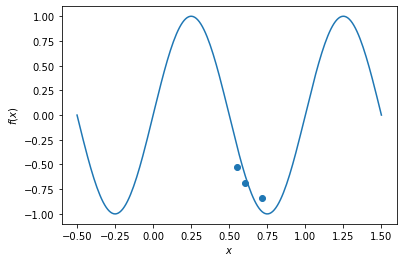

In [4]:
plt.figure()
plt.scatter(x_train, y_train)
plt.plot(x_test, f(x_test))
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.show()

That's not a lot to go on.
Without prior into, it's really easy to get this wrong!

## Model
Here, we define our model structure and add priors to its parameters.

In [5]:
kernel = kernels.Rbf(1)
mean_function = mean_functions.Constant(1)
model = GPR(x_train, y_train, kernel, mean_function=mean_function)

In [6]:
# Now add the priors.
# You can do this to the kernel and mean_function before passing them to the model constructor if you want to.

model.kernel.length_scales.prior = torch.distributions.LogNormal(
    torch.log(TensorType([0.5])), TensorType([1.0])
)
# Std is a priori 0.1->variance is 0.01
model.likelihood.variance.prior = torch.distributions.LogNormal(
    torch.log(TensorType([0.01])), TensorType([1.0])
)
model.mean_function.val.prior = torch.distributions.Normal(
    TensorType([0.0]), TensorType([0.2])
)

## Train the model

In [7]:
# Train
model.optimize(method="L-BFGS-B", max_iter=100)
print("Trained model:")
print(model)

Scipy.optimize.minimize...
loss: 41.285113195766804
loss: 8.006363600735082
loss: 7.413932064944792
loss: 2.8271701304981547
loss: -2.6789617930276317
loss: 1.58178104409369
loss: -2.929702117343241
loss: -1.3150599278696231
loss: -3.008832586557793
loss: 4.5113507451018275
loss: -3.165987929906343
loss: -0.07101449784880254
loss: -3.17200207138492
loss: 14.681060788332758
loss: -3.0514726596297392
loss: -3.1602368154605496
loss: -3.1702846315346016
loss: -3.17173383117766
loss: -3.1719597195717633
loss: -3.171995373059512
loss: -3.172001011695619
loss: -3.1720019037326024
loss: -3.1720020448606396
loss: -3.1720020671885205
loss: -3.1720020707210153
loss: -3.1720020712799117
loss: -3.1720020713682433
loss: -3.172002071382254
loss: -3.172002071384512
loss: -3.1720020713848243
loss: -3.172002071384859
loss: -3.1720020713849224
loss: -3.172002071384859
loss: 8.585123999708077
loss: -3.3089089378744756
loss: -3.065563775138011
loss: -3.3983470503181024
loss: -2.3705466649149405
loss: -3.35

## Predict

In [8]:
# Predict
n_samples = 5

mu, s = model.predict_y(x_test)
y_samp = model.predict_y_samples(x_test, n_samples=n_samples)
unc = 2.0 * np.sqrt(s)

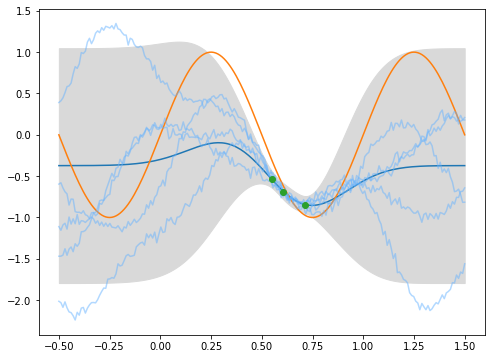

In [9]:
# Show prediction
x_test_plot = x_test.flatten()
plt.figure(figsize=(8, 6))
plt.fill_between(x_test_plot, (mu - unc).flatten(), (mu + unc).flatten(), color=(0.85,) * 3)
plt.plot(x_test_plot, mu)
plt.plot(x_test_plot, f(x_test_plot))
for y_samp_i in y_samp:
    plt.plot(x_test_plot, y_samp_i, color=(0.4, 0.7, 1.0), alpha=0.5)
plt.plot(x_train, y_train, 'o')
plt.show()

Not bad!

## What if we hadn't used priors?
Let's compare the above to a model without priors \[i.e. maximum likelihood estimates (MLE)\].

In [10]:
kernel = kernels.Rbf(1)
mean_function = mean_functions.Constant(1)
model_mle = GPR(x_train, y_train, kernel, mean_function=mean_function)
model_mle.optimize(method="L-BFGS-B", max_iter=100)
print(model_mle)

Scipy.optimize.minimize...
loss: 30.36525692115349
loss: -0.005279603849313919
loss: -0.07393754874343861
loss: -0.163163198551449
loss: -0.1978997941539471
loss: -0.2886205601207563
loss: -0.4731890206965823
loss: -1.276328766016516
loss: 12781.189016036447
loss: 0.9632600852487889
loss: -1.6309005536024421
loss: -1.6799757869306036
loss: -1.4264529094922351
loss: -1.7406690599882704
loss: -1.7159033453508514
loss: -1.8859529531430206
loss: -1.8899562055223433
loss: -1.8983881277336825
loss: -1.8986051401354174
loss: -1.8986127087793343
loss: -1.8986137627236341
loss: -1.8986222568918873
loss: -1.8986247018266593
loss: -1.898625072400153
loss: -1.8986250880609172
loss: -1.8986250940016132
loss: -1.898625121104534
loss: -1.8986251842060793
loss: -1.8986253562123996
loss: -1.8986258000622835
loss: -1.8986269753934368
loss: -1.8986300604969348
loss: -1.898638277732918
loss: -1.8986608752873182
loss: -1.8987315527790742
loss: -1.8992640577509081
loss: -1.0076292908740303
loss: -1.89930444

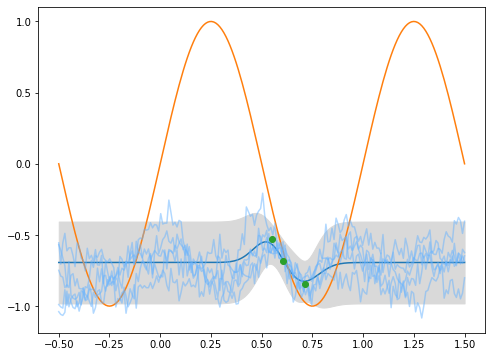

In [11]:
mu_mle, s_mle = model_mle.predict_y(x_test)
y_samp_mle = model_mle.predict_y_samples(x_test, n_samples=n_samples)
unc_mle = 2.0 * np.sqrt(s_mle)

plt.figure(figsize=(8, 6))
plt.fill_between(x_test_plot, (mu_mle - unc_mle).flatten(), (mu_mle + unc_mle).flatten(), color=(0.85,) * 3)
plt.plot(x_test_plot, mu_mle)
plt.plot(x_test_plot, f(x_test_plot))
for y_samp_i in y_samp_mle:
    plt.plot(x_test_plot, y_samp_i, color=(0.4, 0.7, 1.0), alpha=0.5)
plt.plot(x_train, y_train, 'o')
plt.show()

Not nearly as good!